## Running this tutorial 

Unlike most posts on this blog, I do not provide a recipe to run this notebook on Google Colab. I tried it, but it appears that: 

* the disk transfers on the Google Colab virtual machines are too slow. This very much slows down the training of neural networks on relatively large datasets such as the dogs and cats dataset. 
* the number of CPU cores on these machines is too low to handle the heavy image preprocessing that we will need to apply. 

As a consequence, you'll need to run on your machine. 

First, install TensorFlow for your [Linux](https://thedatafrog.com/install-tensorflow-ubuntu/) or [Windows](https://thedatafrog.com/install-tensorflow-windows/) PC. With these recipes, you will also install anaconda, including the keras package. 

Then, install these packages with conda: 

```
conda install numpy matplotlib
```

Clone my github repo locally, and start the notebook:

```
git clone https://github.com/cbernet/maldives.git
cd maldives/dogs_vs_cats
jupyter notebook 
```

And open the notebook `dogs_vs_cats_local.ipynb`.

I haven't tested this recipe, so if it doesn't work, tell me in the comments and I'll help right away.


## The dogs and cats dataset

The dogs and cats dataset was first introduced for a Kaggle competition in 2013. To access the dataset, you will need to create a [Kaggle](https://www.kaggle.com/) account and to log in. No pressure, we're not here for the competition, but to learn! 

The dataset is available [here](https://www.kaggle.com/c/dogs-vs-cats/data). You can use the kaggle utility to get the dataset, or simply download the [train.zip](https://www.kaggle.com/c/dogs-vs-cats/download/train.zip) file (about 540 MB). Don't forget to log in to Kaggle first.  

The instructions to prepare the dataset are for Linux or macOS. If you work on Windows, I'm sure you can easily find a way to do that (e.g. use 7-zip do unpack the archive, and Windows Explorer to create directories and move files around).

Once downloaded, unzip the archive: 

```
unzip train.zip
```

List the contents of the train directory: 

```
ls train 
```

You will see a lot of images of dogs and cats. 

In the next sections, we will use Keras to retrieve images from disk with the  [flow_from_directory](https://keras.io/preprocessing/image/#flow_from_directory) method of the [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) class. 

This method however requires the images from the different classes to be sorted in different directories. So we will put all dog images in `dogs`, and all cat images in `cats`:

```
mkdir cats 
mkdir dogs
find train -name 'dog.*' -exec mv {} dogs/ \;
find train -name 'cat.*' -exec mv {} cats/ \; 
```

You might be wondering why I used `find` instead of a simple `mv` to move the files. It's because with `mv`, the shell needs to pass a very large number of arguments to the command (all the file names), and there is a limitation on this number on macOS (on Linux, it's working fine). With `find`, we can work around this limitation.


## Initialization 

Now, enter in the cell below the location of your dataset directory, the one that contains the `dogs` and `cats` subdirectories, and execute it:

In [3]:
# define and move to dataset directory
datasetdir = '/data2/cbernet/maldives/dogs_vs_cats'
import os
os.chdir(datasetdir)

# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
from tensorflow import keras
# shortcut to the ImageDataGenerator class
ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator


## A first look at the dogs and cats dataset

We can start investigating the dataset by plotting the first picture in each category:

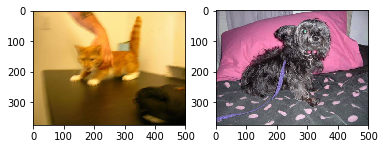

In [11]:
plt.subplot(1,2,1)
plt.imshow(img.imread('cats/cat.0.jpg'))
plt.subplot(1,2,2)
plt.imshow(img.imread('dogs/dog.0.jpg'))

Cute. But let's be more specific and print some information about our images: 

In [12]:
images = []
for i in range(10):
  im = img.imread('cats/cat.{}.jpg'.format(i))
  images.append(im)
  print('image shape', im.shape, 'maximum color level', im.max())


image shape (374, 500, 3) maximum color level 255
image shape (280, 300, 3) maximum color level 255
image shape (396, 312, 3) maximum color level 255
image shape (414, 500, 3) maximum color level 255
image shape (375, 499, 3) maximum color level 255
image shape (144, 175, 3) maximum color level 255
image shape (303, 400, 3) maximum color level 255
image shape (499, 495, 3) maximum color level 255
image shape (345, 461, 3) maximum color level 255
image shape (425, 320, 3) maximum color level 247


In the image shape, the first two columns correspond to the height and width of the image in pixels, respectively, and the third one to the three color channels. So each pixel contains three values (for red, green, and blue, respectively). We also print the maximum color level in each channel, and we can conclude that the RGB levels are in the range 0-255. 

## Pet cleaning: improving the dataset quality

If there is only one thing that you should take away from this tutorial it is this:

**You Should Never Trust Your Data**

The data are always dirty.

To get a close look at this dataset, I used a fast image browser to check all images in the dogs and cats directories. Actually, I simply used the Preview application on my mac to browse through the small preview icons. The brain is very fast to spot obvious issues even if you just let your eyes wander on a large number of pictures. So this (tedious) work took me no more than 20 minutes. But of course, I have certainly missed a lot of less obvious issues.

Anyway, here is what I found.

First, here are the indices for the bad images I could find in each category:


In [13]:
bad_dog_ids = [5604, 6413, 8736, 8898, 9188, 9517, 10161, 
               10190, 10237, 10401, 10797, 11186]

bad_cat_ids = [2939, 3216, 4688, 4833, 5418, 6215, 7377, 
               8456, 8470, 11565, 12272]

We can then retrieve the images with these ids from the `cats` and `dogs` directories:

In [14]:
def load_images(ids, categ):
  '''return the images corresponding to a list of ids'''
  images = []
  dirname = categ+'s' # dog -> dogs
  for theid in ids: 
    fname = '{dirname}/{categ}.{theid}.jpg'.format(
        dirname=dirname,
        categ=categ, 
        theid=theid
    )
    im = img.imread(fname)
    images.append(im)
  return images

In [19]:
bad_dogs = load_images(bad_dog_ids, 'dog')
bad_cats = load_images(bad_cat_ids, 'cat')

In [21]:
def plot_images(images, ids):
    ncols, nrows = 4, 3
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img, theid) in enumerate(zip(images,ids)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img)
      plt.title(str(theid))
      plt.axis('off')


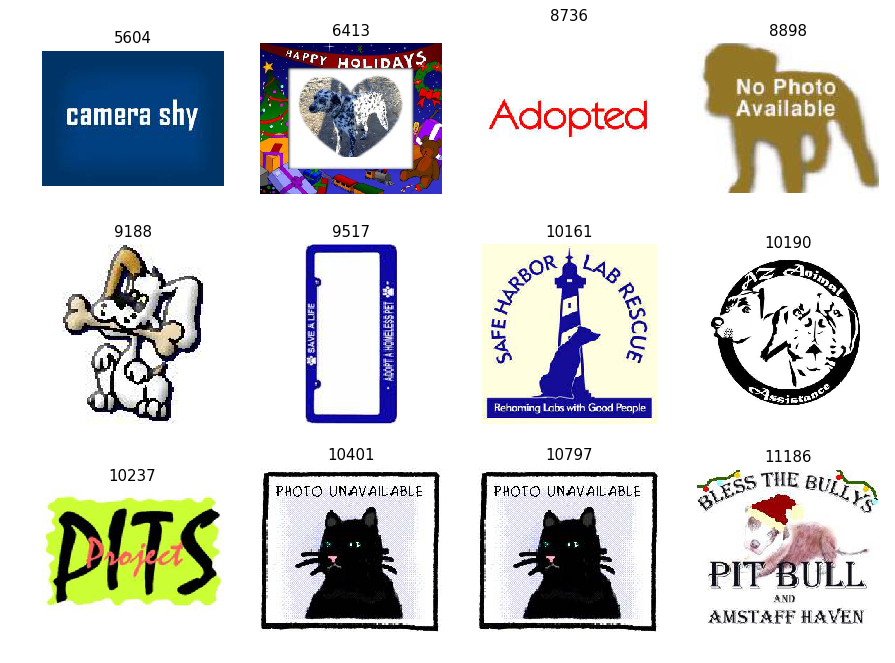

In [22]:
plot_images(bad_dogs, bad_dog_ids)

Some of these images are completely meaningless, like 5604 and 8736.
For 10401 and 10797, we actually see a cat in the picture! sigh... Keeping or not cartoon dogs is debatable. My feeling is that it's going to be better to remove them. Same for 6413, we could keep it, but I'm afraid that the network would focus on the drawings around the dog picture.

Now let's look at the bad cats:



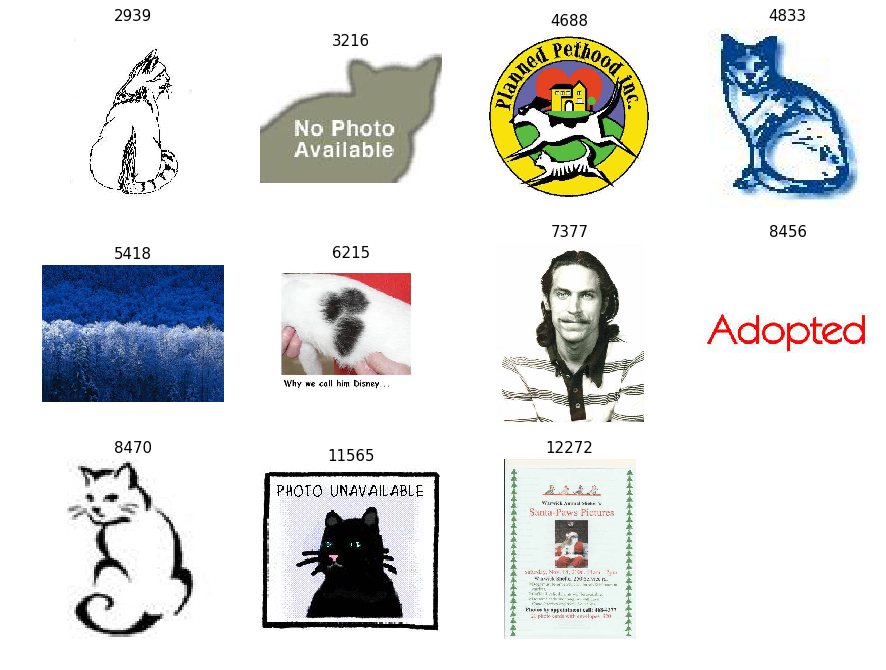

In [23]:
plot_images(bad_cats, bad_cat_ids)

Again, I'm not a fan of keeping cartoon cats for training, but who knows, it could be ok. In image 4688, we have a small cartoon cat and a big cartoon dog... this one should clearly be rejected. In image 6215, we just see fur, so it could be either a cat or a dog, though this does look like cat fur. And why is the guy in image 7377 labeled as a cat? no idea...  

It should however be noted that even if we decide to reject cartoon images for training, the trained network might be able to identify them correctly. 

Now let's implement a small function to clean up the dataset: 

In [24]:
import glob
import re
import shutil

# matches any string with the substring ".<digits>."
# such as dog.666.jpg
pattern = re.compile(r'.*\.(\d+)\..*')

def trash_path(dirname):
    '''return the path of the Trash directory, 
    where the bad dog and bad cat images will be moved.
    Note that the Trash directory should not be within the dogs/ 
    or the cats/ directory, or Keras will still find these pictures.
    '''
    return os.path.join('../Trash', dirname)

def cleanup(ids, dirname): 
  '''move away images with these ids in dirname
  '''
  os.chdir(datasetdir)
  # keep track of current directory
  oldpwd = os.getcwd()
  # go to either cats/ or dogs/
  os.chdir(dirname)
  # create the trash directory. 
  # if it exists, it is first removed
  trash = trash_path(dirname)
  if os.path.isdir(trash):
    shutil.rmtree(trash)
  os.makedirs(trash, exist_ok=True)
  # loop on all cat or dog files
  fnames = os.listdir()
  for fname in fnames:
    m = pattern.match(fname)
    if m: 
      # extract the id
      the_id = int(m.group(1))
      if the_id in ids:
        # this id is in the list of ids to be trashed
        print('moving to {}: {}'.format(trash, fname))
        shutil.move(fname, trash)
  # going back to root directory
  os.chdir(oldpwd)
  
def restore(dirname):
  '''restores files in the trash
  I will need this to restore this tutorial to initial state for you
  and you might need it if you want to try training the network
  without the cleaning of bad images
  '''
  os.chdir(datasetdir)
  oldpwd = os.getcwd()
  os.chdir(dirname)
  trash = trash_path(dirname)
  print(trash)
  for fname in os.listdir(trash):
    fname = os.path.join(trash,fname)
    print('restoring', fname)
    print(os.getcwd())
    shutil.move(fname, os.getcwd())
  os.chdir(oldpwd)
 

In [25]:
cleanup(bad_cat_ids,'cats')

moving to ../Trash/cats: cat.4688.jpg
moving to ../Trash/cats: cat.6215.jpg
moving to ../Trash/cats: cat.11565.jpg
moving to ../Trash/cats: cat.8470.jpg
moving to ../Trash/cats: cat.3216.jpg
moving to ../Trash/cats: cat.2939.jpg
moving to ../Trash/cats: cat.4833.jpg
moving to ../Trash/cats: cat.8456.jpg
moving to ../Trash/cats: cat.7377.jpg
moving to ../Trash/cats: cat.12272.jpg
moving to ../Trash/cats: cat.5418.jpg


In [26]:
cleanup(bad_dog_ids, 'dogs')

moving to ../Trash/dogs: dog.10190.jpg
moving to ../Trash/dogs: dog.10797.jpg
moving to ../Trash/dogs: dog.5604.jpg
moving to ../Trash/dogs: dog.10237.jpg
moving to ../Trash/dogs: dog.8736.jpg
moving to ../Trash/dogs: dog.6413.jpg
moving to ../Trash/dogs: dog.10161.jpg
moving to ../Trash/dogs: dog.8898.jpg
moving to ../Trash/dogs: dog.9517.jpg
moving to ../Trash/dogs: dog.10401.jpg
moving to ../Trash/dogs: dog.9188.jpg
moving to ../Trash/dogs: dog.11186.jpg


If you want to restore your dataset to its original version before cleaning, just uncomment and execute the following:

In [28]:
# restore('dogs')
# restore('cats')

## Load the dogs and cats image dataset with Keras 

Neural networks are trained by presenting them with batches of images, each of them with a label identifying the true nature of the image (either cat or dog in our case). A batch may contain of the order of a few tenths to a couple hundred images. If you want an introduction to neural networks and supervised learning for classification, you can check out my post on [Handwritten Digit Recognition with scikit-learn](https://thedatafrog.com/handwritten-digit-recognition-scikit-learn/). 

For each image, the prediction of the network is compared with the corresponding label, and the distance between the predictions of the network and the truth is evaluated for the whole batch. Then, after the processing of the batch, the network parameters are changed in a way to minimize this distance, therefore improving the prediction capability of the network. The training then proceeds iteratively, batch after batch. 

So we need a way to turn our images, now files on disk, into batches of data arrays in memory that can be fed to the network during training.

The [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) can readily be used for this purpose. Let's import this class and create an instance of the generator: 



In [29]:
gen = ImageDataGenerator()

Now, we will use the  [flow_from_directory](https://keras.io/preprocessing/image/#flow_from_directory) method of the `gen` object to start generating batches. 

This method will return an iterator that returns a batch everytime it's iterated on. To see how the data is organized, we can simply create this iterator, and get a first batch to look at it: 

In [30]:
iterator = gen.flow_from_directory(
    os.getcwd(), 
    target_size=(256,256), 
    classes=('dogs','cats')
)

Found 24977 images belonging to 2 classes.


In [31]:
# we can guess that the iterator has a next function, 
# because all python iterators have one. 
batch = iterator.next()
len(batch)

2

The batch has two elements. What's their type? 

In [32]:
print(type(batch[0]))
print(type(batch[1]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Two numpy arrays! well, it means we can print their shape and type: 

In [33]:
print(batch[0].shape)
print(batch[0].dtype)
print(batch[0].max())
print(batch[1].shape)
print(batch[1].dtype)


(32, 256, 256, 3)
float32
255.0
(32, 2)
float32


Obviously, the first element is an array of 32 images with 256x256 pixels, and 3 color channels, encoded as floats in the range 0 to 255. So the ImageDataGenerator did force the image to 256x256 pixels as requested, but didn't normalize the color levels between 0 and 1. We will have to do that later. 

The second element contains the 32 corresponding labels. 

Before having a detailed look at the labels, we can plot the first image: 

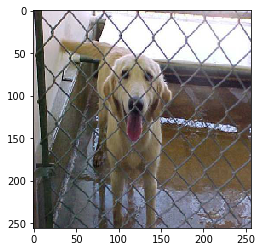

In [35]:
import numpy as np
# we need to cast the image array to integers 
# before plotting as imshow either takes arrays of integers, 
# or arrays of floats normalized to 1. 
plt.imshow(batch[0][0].astype(np.int))

And here is the corresponding label: 

In [36]:
batch[1][0]

array([1., 0.], dtype=float32)

We see that the [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) automatically produced a label for each image depending on the directory in which it was found. One-hot encoding is used for the labels, and this is precisely what we need for the classification task we are up to. If you want to know more about one-hot encoding, check my post about a [First Neural Network with Keras](https://thedatafrog.com/first-neural-network-keras/#Preparing-the-dataset). 

We can also guess that the label `[0., 1.]` corresponds to a true cat, and `[1.,0.]` to a true dog. The prediction of the network for a given image will lie somewhere in between, like `[0.6,0.4]` for a dog. Still, that's only a guess, and a guess is not enough! we need to be sure, or we take the risk to feed our network with mislabeled images (and garbage in, garbage out). 

Since it might be the first time you use the ImageDataGenerator, you probably want to get more confident about this tool. For that, we are going to develop a small function in the next section to validate the input dataset.  

## Pet plotting for label validation

To validate the dataset labels, we want to check that, for a few batches, the labels are correctly set. So we need a function that can plot a fairly large number of images and label them. Here it is: 

In [37]:
def plot_images(batch):
    imgs = batch[0]
    labels = batch[1]
    ncols, nrows = 4,8
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img,label) in enumerate(zip(imgs,labels)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img.astype(np.int))
      assert(label[0]+label[1]==1.)
      categ = 'dog' if label[0]>0.5 else 'cat'
      plt.title( '{} {}'.format(str(label), categ))
      plt.axis('off')


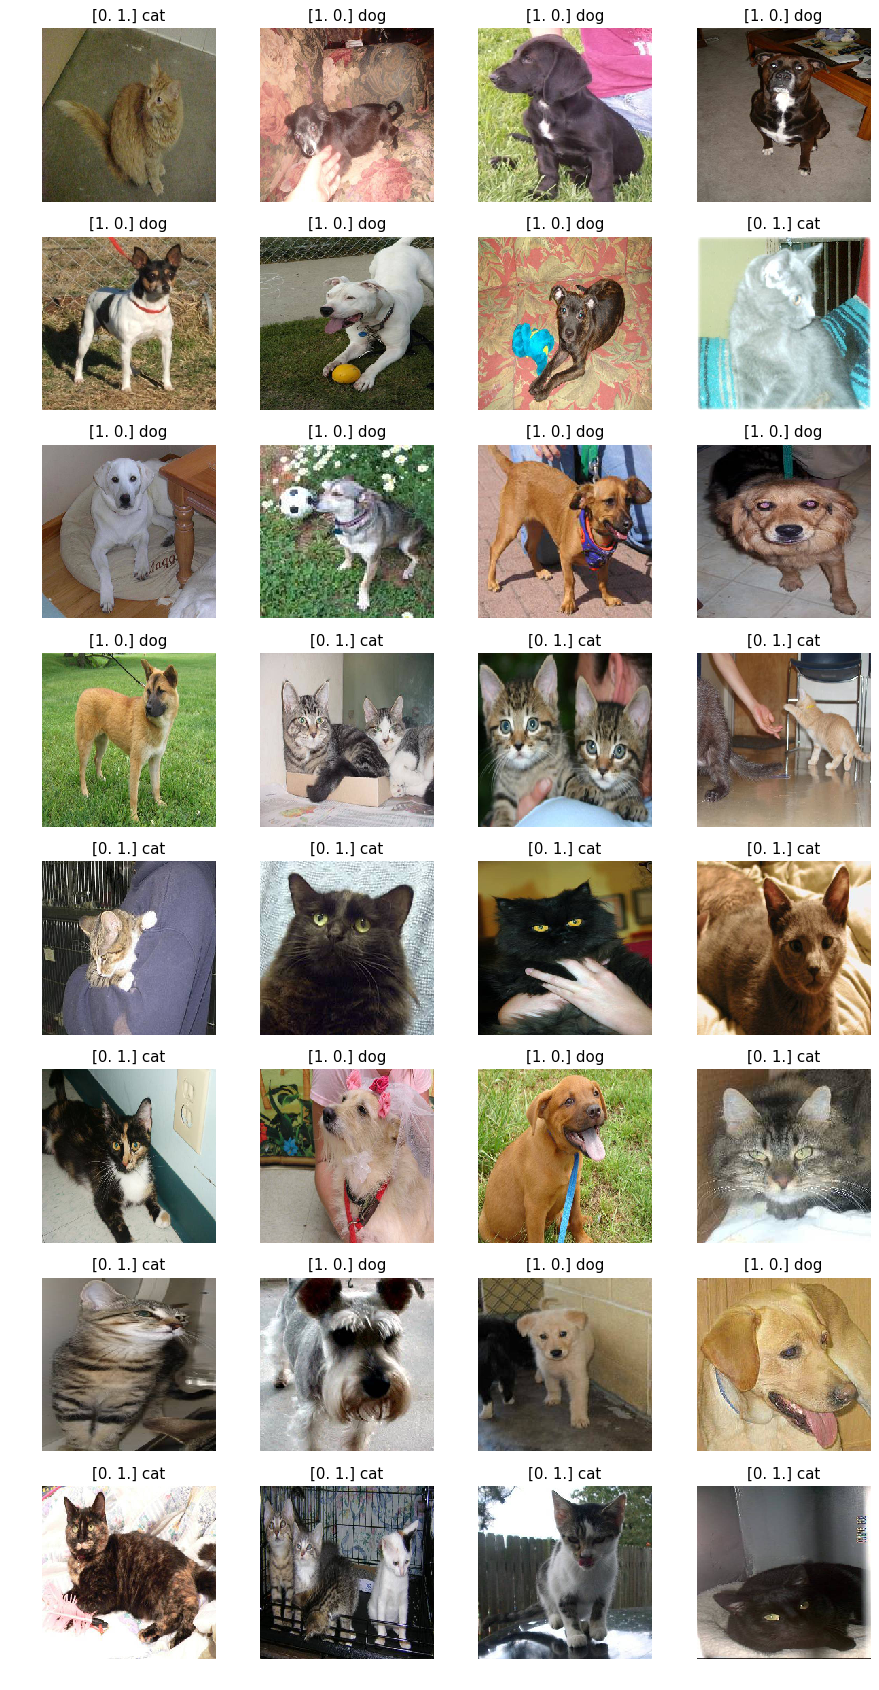

In [38]:
plot_images(iterator.next())

Please repeat the previous cell until you are confident that the labels are correct. 


## Split the training and validation samples with ImageDataGenerator

We will train our neural network on a subset of the dog and cat images called the *training dataset*. 

If a network is complex enough (if it has enough parameters), it can start [overfitting](https://thedatafrog.com/overfitting-illustrated/), which means that it is able to learn the specific features of the images in the training dataset. In other words, the network looses its generality, and its ability to classify an arbitrary image as a dog or cat image. 

To make sure that overfitting does not occur, we will evaluate the performance of the network on a *validation dataset*, disjoint from the training dataset. 

Let's first create a new `ImageDataGenerator`. With respect to the previous one, we request to: 

* rescale all color levels to be in the range 0-1. We're doing this because neural nets behave better on input variables of the order of unity. 
* use 20% of the images for validation, and thus 80% for the training. 

In [2]:
imgdatagen = ImageDataGenerator(
    rescale = 1/255., 
    validation_split = 0.2,
)

Next, we define our iterators for the training and validation datasets. We use a batch size of 30 because, typically, networks are not able to learn if the batch size is too large or too small. You may try again with a different batch size after completing this tutorial. 

The images are forced to 256x256 pixels. Here, we just need to make sure that the format of all images is the same, as the convolutional neural network that we're going to use has a fixed number of inputs. I chose a square shape to avoid getting too much distortion on both landscape and portrait pictures. But if the vast majority of our images is portrait, maybe a shape that is closer to portrait would be a better choice. I didn't check that. 

In [3]:
batch_size = 30
height, width = (256,256)

train_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('dogs','cats'),
    batch_size = batch_size,
    subset = 'training'
)

val_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('dogs','cats'),
    batch_size = batch_size,
    subset = 'validation'
)

Found 19983 images belonging to 2 classes.
Found 4994 images belonging to 2 classes.


## A simple convolutional neural network

Deep convolutional neural networks are the go-to choice when it comes to classifying images. For a detailed introduction to this kind of networks, see my post on [Tuning such a network for handwritten digit recognition](https://thedatafrog.com/deep-learning-keras/). The model below is very similar to the one we have used in this article. 

In [4]:
model = keras.models.Sequential()

initializers = {
    
}
model.add( 
    keras.layers.Conv2D(
        24, 5, input_shape=(256,256,3), 
        activation='relu', 
    )
)
model.add( keras.layers.MaxPooling2D(2) )
model.add( 
    keras.layers.Conv2D(
        48, 5, activation='relu', 
    )
)
model.add( keras.layers.MaxPooling2D(2) )
model.add( 
    keras.layers.Conv2D(
        96, 5, activation='relu', 
    )
)
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dropout(0.9) )

model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 24)      1824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 24)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 48)      28848     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 96)        115296    
_________________________________________________________________
flatten (Flatten)            (None, 311904)            0         
_________________________________________________________________
dropout (Dropout)            (None, 311904)            0         
__________

Here are the main differences with respect to the network used for handwritten digits recognition: 

* we have two neurons in the last softmax layer instead of 10, as we now have two categories. 
* our input images are much larger, 256x256 instead of 28x28. Note that the `input_shape` of the first layer has to match the shape given to the generator. 
* I have added a third convolutional layer, and I'm extracting more features at each layer. 
* the dropout rate was increased from 0.4 to 0.9 to help reduce overfitting. 

The first two points are kind of technical, we just need to do this or the network will not run. 

The last two points are far from being obvious. These choices come from a long optimization. I started with two convolutional layers and less features, but the training accuracy was plateauing, which is a sign that the network was [underfitting](https://thedatafrog.com/overfitting-illustrated/). This means that the network did not have enough parameters to describe the training dataset. So let alone the validation dataset...

So I increased the complexity by adding a layer, and by increasing the number of extracted features in each layer until the training accuracy could reach almost 100%. 

At that point, the network was [overfitting](https://thedatafrog.com/overfitting-illustrated/): the validation accuracy was much lower than the training accuracy. So I increased the [dropout](https://thedatafrog.com/deep-learning-keras/#Dropout-layers) rate slowly from 0.4 to 0.9 to tame overfitting, and actually reached this fairly high value. This means that before entering the last dense layer for classification, the dropout layer drops 90% of the variables from the previous stages of the network on a random basis. That's a lot! 

To train a neural network, we need to use an optimizer. This tool decides how to change the parameters of the network after each batch to minimize the distance between the network output and the truth. Among the [optimizers implemented in Keras](https://keras.io/optimizers/), people often choose Adam, or RMSProp, often as a matter of habit. 

But in this case, these optimizers are not working well. The network very often starts training in a bad configuration very far from the optimal set of parameters, and is not able to learn. The loss starts around 8, and does not improve. As a result, the training accuracy remains at 50%, which is equivalent to a random guess. 

So I fell back to Stochastic Gradient Descent (SGD). It works well, and the network learns. But the training is veeery long. And, by the way, this is the reason why people invented boosted optimizers such as Adam or RMSProp. 

In all these studies, I tried to vary wildly the learning rate, to no avail. 

I then read the paper about [Adam, A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8), and decided to give a try to AdaMax, a variant of Adam: 

In [5]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=0.001),
              metrics=['acc'])


After compiling the model, we train it on the training dataset, validating the results at the end of each epoch with the validation dataset. I'm using 10 cores of my CPU to handle the ImageDataGenerator tasks, and two GeForce GTX 1080 Ti for TensorFlow. 

Each epoch should take about one minute. If it takes much more, like twenty minutes, you should make sure that you are indeed making use of your GPU. Check out your installation of the nvidia drivers and TensorFlow on [Linux](https://thedatafrog.com/install-tensorflow-ubuntu/) or [Windows](https://thedatafrog.com/install-tensorflow-windows/).

In [6]:
history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=20,
)

Epoch 1/20
667/667 [==============================] - 52s 78ms/step - loss: 0.5967 - acc: 0.6691 - val_loss: 0.5249 - val_acc: 0.7437
Epoch 2/20
667/667 [==============================] - 48s 72ms/step - loss: 0.5108 - acc: 0.7454 - val_loss: 0.4759 - val_acc: 0.7717
Epoch 3/20
667/667 [==============================] - 48s 71ms/step - loss: 0.4644 - acc: 0.7815 - val_loss: 0.4619 - val_acc: 0.7827
Epoch 4/20
667/667 [==============================] - 47s 71ms/step - loss: 0.4261 - acc: 0.8056 - val_loss: 0.4290 - val_acc: 0.8008
Epoch 5/20
667/667 [==============================] - 49s 73ms/step - loss: 0.3907 - acc: 0.8240 - val_loss: 0.4173 - val_acc: 0.8180
Epoch 6/20
667/667 [==============================] - 47s 71ms/step - loss: 0.3675 - acc: 0.8381 - val_loss: 0.3869 - val_acc: 0.8350
Epoch 7/20
667/667 [==============================] - 47s 71ms/step - loss: 0.3457 - acc: 0.8488 - val_loss: 0.3641 - val_acc: 0.8368
Epoch 8/20
667/667 [==============================] - 48s 73ms

Now that the training is done, we need a way to see how the training worked. For this, we'll write a small function to plot the loss and the accuracy for both the training and validation datasets, as a function of the epoch:

In [10]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

And here are the results: 

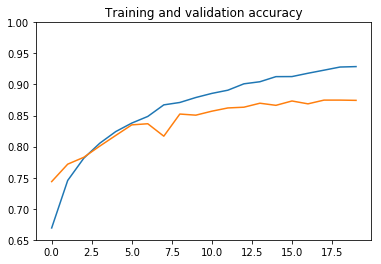

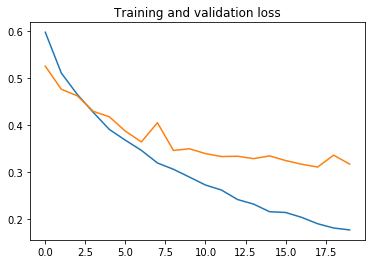

In [9]:

plot_history(history, (0.65, 1.))

We can conclude the following: 

* The training accuracy is not able to approach 100% because of the large dropout rate. 
* The network starts overfitting at epoch 6, even with such a large dropout rate. 
* The validation accuracy plateaus around 87%, which is not too bad. 

We cannot increase dropout further, so we would need more data to do a better job. In the next section, we will see how to use data augmentation to generate more training images from the ones we already have. That's going to be much easier and much faster than collecting and tagging new cat and dog images.

## Data augmentation

Data augmentation consists in generating new training examples from the ones we already have, in such a way as to increase artificially the size of the training sample. That's very easy to do with the ImageDataGenerator. For example, we can start by randomly flipping left and right in our images: 

In [4]:
imgdatagen = ImageDataGenerator(
    rescale = 1/255., 
    horizontal_flip = True, 
    validation_split = 0.2,
)

Let's see the effect of this transformation on a given image:

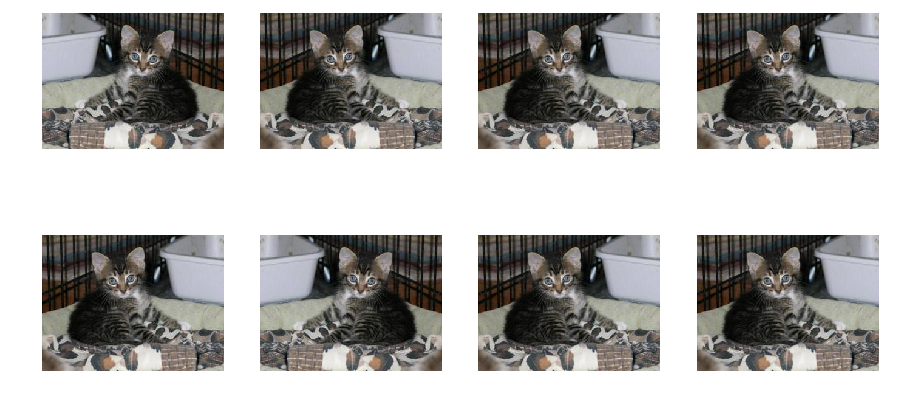

In [5]:
image = img.imread('cats/cat.12.jpg')

def plot_transform():
    '''apply the transformation 8 times randomly'''
    nrows, ncols = 2,4
    fig = plt.figure(figsize=(ncols*3, nrows*3), dpi=90)
    for i in range(nrows*ncols): 
        timage = imgdatagen.random_transform(image)
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(timage)
        plt.axis('off')
        
plot_transform()

You should be able to see the effect of the horizontal flip, except if you're really unlucky! 

Now, let's make the transformation a bit more complex. This time, the ImageDataGenerator will flip, zoom, and rotate the images on a random basis: 

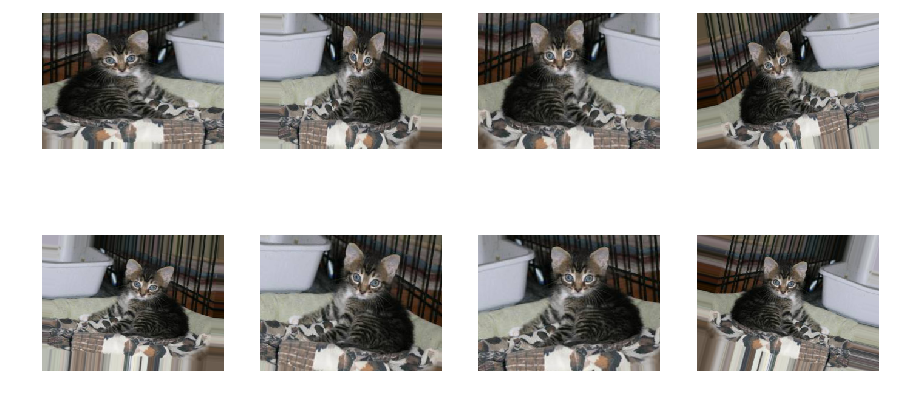

In [6]:
imgdatagen = ImageDataGenerator(
    rescale = 1/255., 
    horizontal_flip = True, 
    zoom_range = 0.3, 
    rotation_range = 15.,
    validation_split = 0.1,
)

plot_transform()

We have seen that these transformations produce new images that are perfectly acceptable. So let's retrain the network with data augmentation. It is important to note that, due to the random nature of the transformations, the network will see each image only once. We can therefore expect that it will be difficult for the network to overfit. 

In [5]:
batch_size = 30
height, width = (256,256)

train_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('dogs','cats'),
    batch_size = batch_size,
    subset = 'training'
)

val_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('dogs','cats'),
    batch_size = batch_size,
    subset = 'validation'
)

Found 22481 images belonging to 2 classes.
Found 2496 images belonging to 2 classes.


With data augmentation, there is no need for a large dropout rate anymore. I reduced it from 0.9 to 0.2 but I haven't tried to tune this parameter: 

In [6]:
model = keras.models.Sequential()

initializers = {
    
}
model.add( 
    keras.layers.Conv2D(
        24, 5, input_shape=(256,256,3), 
        activation='relu', 
    )
)
model.add( keras.layers.MaxPooling2D(2) )
model.add( 
    keras.layers.Conv2D(
        48, 5, activation='relu', 
    )
)
model.add( keras.layers.MaxPooling2D(2) )
model.add( 
    keras.layers.Conv2D(
        96, 5, activation='relu', 
    )
)
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dropout(0.2) )

model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 24)      1824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 24)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 48)      28848     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 96)        115296    
_________________________________________________________________
flatten (Flatten)            (None, 311904)            0         
_________________________________________________________________
dropout (Dropout)            (None, 311904)            0         
__________

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=0.001),
              metrics=['acc'])


In [8]:
history_augm = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=40,
)

Epoch 1/40
750/750 [==============================] - 157s 210ms/step - loss: 0.6404 - acc: 0.6483 - val_loss: 0.6010 - val_acc: 0.6775
Epoch 2/40
750/750 [==============================] - 152s 203ms/step - loss: 0.5433 - acc: 0.7251 - val_loss: 0.4905 - val_acc: 0.7648
Epoch 3/40
750/750 [==============================] - 152s 203ms/step - loss: 0.4931 - acc: 0.7637 - val_loss: 0.4796 - val_acc: 0.7664
Epoch 4/40
750/750 [==============================] - 152s 202ms/step - loss: 0.4619 - acc: 0.7806 - val_loss: 0.4358 - val_acc: 0.8025
Epoch 5/40
750/750 [==============================] - 154s 205ms/step - loss: 0.4272 - acc: 0.8059 - val_loss: 0.4098 - val_acc: 0.8113
Epoch 6/40
750/750 [==============================] - 151s 202ms/step - loss: 0.4021 - acc: 0.8178 - val_loss: 0.4086 - val_acc: 0.8205
Epoch 7/40
750/750 [==============================] - 153s 203ms/step - loss: 0.3769 - acc: 0.8323 - val_loss: 0.3560 - val_acc: 0.8425
Epoch 8/40
750/750 [============================

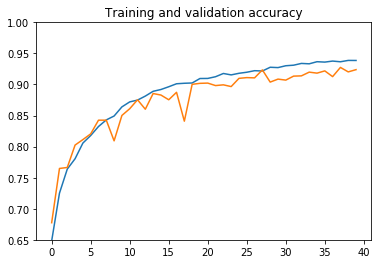

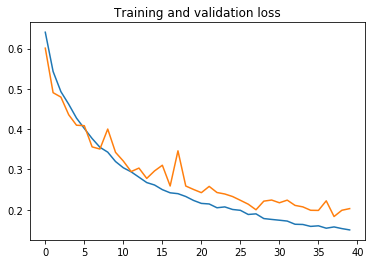

In [11]:
plot_history(history_augm, (0.65, 1))

As you can see, with data augmentation, the training takes longer, but overfitting is much reduced, and we could reach a classification accuracy of 92%. 

We could keep tuning the network to limit overfitting by maybe increasing a bit the dropout rate, and train more. But I guess we're not going to be able to reach 95% on this dataset. 

Fortunately, there are other ways, as we're going to see. 

## Using a pre-trained model : ResNet50

Many clever people have been working on image recognition, with powerful hardware and very large datasets. I don't know about you, but I don't have that. 

However, what we can do is to use their networks directly. Such networks are called *pre-trained models*. Because these models could be trained on very large datasets, they usually have a deep and complex architecture, and are extremely powerful. These models can be downloaded with their parameters set to the values they had at the end of the training. In this way, we can easily get excellent performance without training a new model ourselves.

Here is the list of [pre-trained models available in keras](https://keras.io/applications/).  

I decided to use [ResNet50](https://arxiv.org/abs/1512.03385), a model trained on the [ImageNet](http://www.image-net.org/) dataset, which contains 14 million images belonging to 1000 categories. 

First, we download and build the model in just a few lines of code: 

In [3]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

Then, we define a small utility function to evaluate the model on an input image, and we call this function on a couple pictures in our dataset: 

In [8]:
def evaluate(img_fname):
    img = image.load_img(img_fname, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    # print the probability and category name for the 5 categories 
    # with highest probability: 
    print('Predicted:', decode_predictions(preds, top=5)[0])
    plt.imshow(img)

Predicted: [('n02102318', 'cocker_spaniel', 0.29664052), ('n02097298', 'Scotch_terrier', 0.14396854), ('n02097130', 'giant_schnauzer', 0.14393643), ('n02110627', 'affenpinscher', 0.10783979), ('n02088094', 'Afghan_hound', 0.04753604)]


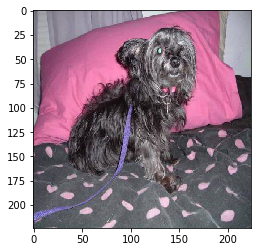

In [11]:
evaluate('dogs/dog.0.jpg')

Predicted: [('n02099849', 'Chesapeake_Bay_retriever', 0.87790024), ('n02105412', 'kelpie', 0.06544642), ('n02099712', 'Labrador_retriever', 0.008923257), ('n02106550', 'Rottweiler', 0.005405719), ('n02099429', 'curly-coated_retriever', 0.004976345)]


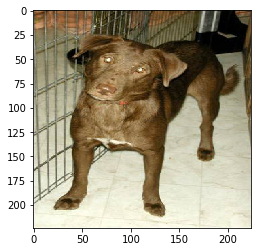

In [12]:
evaluate('dogs/dog.1.jpg')

Predicted: [('n02108551', 'Tibetan_mastiff', 0.2795359), ('n02097474', 'Tibetan_terrier', 0.21642059), ('n02106030', 'collie', 0.21163173), ('n02106166', 'Border_collie', 0.06243812), ('n02108000', 'EntleBucher', 0.040746134)]


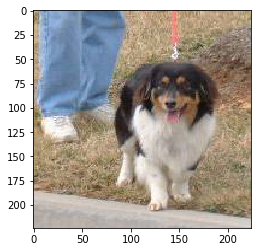

In [13]:
evaluate('dogs/dog.2.jpg')

As you can see, the network gives dogs in the top categories, and is even to predict, to a large extent, the race of the dog! 

What about cats? 

Predicted: [('n04404412', 'television', 0.10631036), ('n02094258', 'Norwich_terrier', 0.10413598), ('n02085620', 'Chihuahua', 0.075974055), ('n02093991', 'Irish_terrier', 0.07585583), ('n02123045', 'tabby', 0.07348687)]


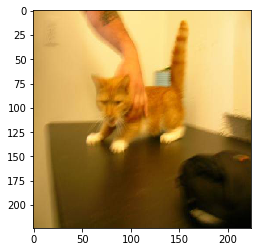

In [14]:
evaluate('cats/cat.0.jpg')

Here is does not work that well. The top category is television, presumably because of the low quality of the image. And then we get dogs that are of this color, and finally a cat. For the next picture, the network is behaving in a better way: 

Predicted: [('n02123045', 'tabby', 0.6946943), ('n02123159', 'tiger_cat', 0.18619044), ('n02124075', 'Egyptian_cat', 0.06427032), ('n02127052', 'lynx', 0.00819175), ('n03958227', 'plastic_bag', 0.004613503)]


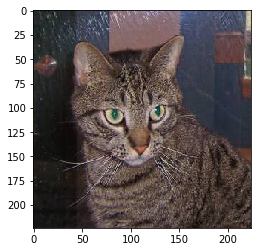

In [15]:
evaluate('cats/cat.1.jpg')

Now let's try with dog cartoons: 

Predicted: [('n02088466', 'bloodhound', 0.11124672), ('n03000684', 'chain_saw', 0.1000548), ('n03814639', 'neck_brace', 0.04567196), ('n03825788', 'nipple', 0.035572648), ('n03803284', 'muzzle', 0.030304618)]


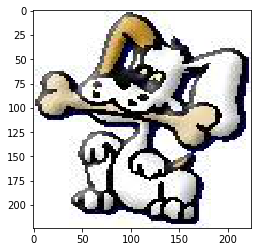

In [17]:
evaluate('Trash/dogs/dog.9188.jpg')

The top-probability category is indeed a dog! ... closely followed by a chain saw. Now what about the cover picture of this blog post?  

Predicted: [('n02106662', 'German_shepherd', 0.27522734), ('n02113023', 'Pembroke', 0.17356005), ('n03803284', 'muzzle', 0.12873776), ('n02109047', 'Great_Dane', 0.06609615), ('n02114712', 'red_wolf', 0.060678747)]


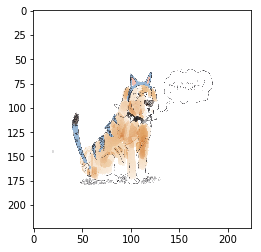

In [21]:
# download the image from my github repository
import urllib.request as req
url = 'https://raw.githubusercontent.com/cbernet/maldives/master/dogs_vs_cats/datafrog_chien_chat.png' 
req.urlretrieve(url, 'dog_cartoon.jpg')

evaluate('dog_cartoon.jpg')

The network did not get fooled by the cosplay: it's a dog! 

Ok we had fun with ResNet50, but the network is not doing exactly what we want, which is to classify pictures as dog or cat. To do this with a model based on ImageNet, we would need to be able to find out that a fine-grained category such as `Great_Dane` actually belongs to the coarser `dog` category. Until we do that, we cannot quantify the performance of this model in the context of our problem. 

We could do that by hand, but we'll instead learn a more elegant solution in the next article. 
